In [1]:
import sys
sys.path.append("../")
import numpy as np
import matplotlib.pyplot as plt
import scripts.theodolite_utils as theodo_u
import scripts.theodolite_plot_function as theodo_p
import scripts.groundtruth_utils as theodo_g
from numpy import linalg
import importlib
theodo_u = importlib.reload(theodo_u)
theodo_p = importlib.reload(theodo_p)

In [2]:
theodo_u = importlib.reload(theodo_u)
path = "../data/20220224/uncertainty/interpolation/MC_Fake_0_0_0_0_0_"
MC1_0 = theodo_u.read_point_uncertainty_csv_file(path+"1.csv")
MC2_0 = theodo_u.read_point_uncertainty_csv_file(path+"2.csv")
MC3_0 = theodo_u.read_point_uncertainty_csv_file(path+"3.csv")
path = "../data/20220224/uncertainty/interpolation/MC_Fake_1_0_0_0_0_"
MC1_1 = theodo_u.read_point_uncertainty_csv_file(path+"1.csv")
MC2_1 = theodo_u.read_point_uncertainty_csv_file(path+"2.csv")
MC3_1 = theodo_u.read_point_uncertainty_csv_file(path+"3.csv")
path = "../data/20220224/uncertainty/interpolation/MC_Fake_0_1_0_0_0_"
MC1_2 = theodo_u.read_point_uncertainty_csv_file(path+"1.csv")
MC2_2 = theodo_u.read_point_uncertainty_csv_file(path+"2.csv")
MC3_2 = theodo_u.read_point_uncertainty_csv_file(path+"3.csv")
path = "../data/20220224/uncertainty/interpolation/MC_Fake_0_0_1_0_0_"
MC1_3 = theodo_u.read_point_uncertainty_csv_file(path+"1.csv")
MC2_3 = theodo_u.read_point_uncertainty_csv_file(path+"2.csv")
MC3_3 = theodo_u.read_point_uncertainty_csv_file(path+"3.csv")
path = "../data/20220224/uncertainty/interpolation/MC_Fake_1_1_1_0_0_"
MC1_4 = theodo_u.read_point_uncertainty_csv_file(path+"1.csv")
MC2_4 = theodo_u.read_point_uncertainty_csv_file(path+"2.csv")
MC3_4 = theodo_u.read_point_uncertainty_csv_file(path+"3.csv")

In [ ]:
print(len(MC1_0),len(MC1_1),len(MC1_2),len(MC1_3),len(MC1_4))

In [ ]:
theodo_g = importlib.reload(theodo_g)
Distance_DC_total = []
Distance_DC_total.append(theodo_g.distance_dc_comparison(MC1_0,MC2_0,MC3_0,MC1_1,MC2_1,MC3_1))
Distance_DC_total.append(theodo_g.distance_dc_comparison(MC1_0,MC2_0,MC3_0,MC1_2,MC2_2,MC3_2))
Distance_DC_total.append(theodo_g.distance_dc_comparison(MC1_0,MC2_0,MC3_0,MC1_3,MC2_3,MC3_3))
Distance_DC_total.append(theodo_g.distance_dc_comparison(MC1_0,MC2_0,MC3_0,MC1_4,MC2_4,MC3_4))

In [ ]:
theodo_g = importlib.reload(theodo_g)
Distance_H_total = []
Distance_H_total.append(theodo_g.distance_h_comparison(MC1_0,MC2_0,MC3_0,MC1_1,MC2_1,MC3_1))
Distance_H_total.append(theodo_g.distance_h_comparison(MC1_0,MC2_0,MC3_0,MC1_2,MC2_2,MC3_2))
Distance_H_total.append(theodo_g.distance_h_comparison(MC1_0,MC2_0,MC3_0,MC1_3,MC2_3,MC3_3))
Distance_H_total.append(theodo_g.distance_h_comparison(MC1_0,MC2_0,MC3_0,MC1_4,MC2_4,MC3_4))

In [5]:
theodo_g = importlib.reload(theodo_g)
Distance_F_total = []
Distance_F_total.append(theodo_g.distance_F_comparison(MC1_0,MC2_0,MC3_0,MC1_1,MC2_1,MC3_1))
Distance_F_total.append(theodo_g.distance_F_comparison(MC1_0,MC2_0,MC3_0,MC1_2,MC2_2,MC3_2))
Distance_F_total.append(theodo_g.distance_F_comparison(MC1_0,MC2_0,MC3_0,MC1_3,MC2_3,MC3_3))
Distance_F_total.append(theodo_g.distance_F_comparison(MC1_0,MC2_0,MC3_0,MC1_4,MC2_4,MC3_4))

In [ ]:
data = Distance_DC_total
fig, ax = plt.subplots()
ax.boxplot(data, showfliers=False, notch=False)
#ax.set_xticklabels(['RTS + Tilt'])
ax.set_xticklabels(['RTS + Tilt', 'RTS + \nAtmospheric', 'RTS + \nExtrinsic calib', 'RTS + All'])
#ax.set_yscale('log')
plt.show()

In [ ]:
data = Distance_H_total
fig, ax = plt.subplots()
ax.boxplot(data, showfliers=False, notch=False)
#ax.set_xticklabels(['RTS + Tilt'])
ax.set_xticklabels(['RTS + Tilt', 'RTS + \nAtmospheric', 'RTS + \nExtrinsic calib', 'RTS + All'])
ax.set_yscale('log')
# plt.savefig("../figs/uncertainty/boxplot_influence.jpg")
plt.show()

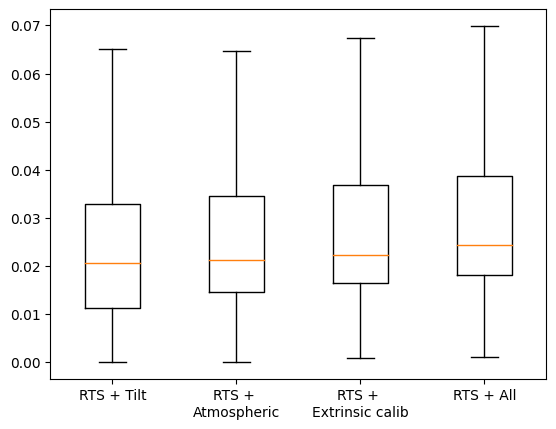

In [6]:
data = Distance_F_total
fig, ax = plt.subplots()
ax.boxplot(data, showfliers=False, notch=False)
#ax.set_xticklabels(['RTS + Tilt'])
ax.set_xticklabels(['RTS + Tilt', 'RTS + \nAtmospheric', 'RTS + \nExtrinsic calib', 'RTS + All'])
#ax.set_yscale('log')
plt.show()